# Student Results Prediction

## Problem Statement  
Educational institutions often struggle to identify students at risk of underperforming in standardized tests such as the JAMB examination.  
Accurately predicting test scores in advance can help schools provide targeted interventions, allocate resources more effectively,  
and support students in areas where they are most likely to struggle.  

This project develops a predictive model that uses demographic, academic, and behavioral data to estimate students’ JAMB scores.  
The goal is to assess whether such a model can provide actionable insights for improving educational outcomes.

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mutual_info_score, root_mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Data Wrangling

In [2]:
path = '/home/samhulud/projects/jamb-results-prediction/data/jamb_exam_results.csv'
df = pd.read_csv(path)
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [3]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [4]:
categorical_cols = list(df.dtypes[df.dtypes=='object'].index)

In [5]:
for col in categorical_cols:
    df[col] = df[col].str.strip().str.lower().str.replace(' ', '_')

In [6]:
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,public,urban,yes,yes,high,medium,1,17,male,low,tertiary,2
1,207,14,88,4,2.7,public,rural,no,yes,high,high,2,15,male,high,NaN,1
2,182,29,87,2,9.6,public,rural,yes,yes,high,medium,3,20,female,high,tertiary,2
3,210,29,99,2,2.6,public,urban,no,yes,medium,high,4,22,female,medium,tertiary,1
4,199,12,98,3,8.8,public,urban,no,yes,medium,medium,5,22,female,medium,tertiary,1


In [7]:
df.isnull().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
student_id                        0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [8]:
df.parent_education_level.unique()

array(['tertiary', nan, 'primary', 'secondary'], dtype=object)

Instead of leaving the null values, I will replace them with `unstated`.

In [9]:
df.parent_education_level = df.parent_education_level.fillna('unstated')

In [10]:
df.parent_education_level.unique()

array(['tertiary', 'unstated', 'primary', 'secondary'], dtype=object)

## EDA

### Categorical features

In [11]:
for col in categorical_cols:
    print("Column:", col)
    display(df[col].nunique())
    display(df[col].unique()[:5])
    print()

Column: school_type


2

array(['public', 'private'], dtype=object)


Column: school_location


2

array(['urban', 'rural'], dtype=object)


Column: extra_tutorials


2

array(['yes', 'no'], dtype=object)


Column: access_to_learning_materials


2

array(['yes', 'no'], dtype=object)


Column: parent_involvement


3

array(['high', 'medium', 'low'], dtype=object)


Column: it_knowledge


3

array(['medium', 'high', 'low'], dtype=object)


Column: gender


2

array(['male', 'female'], dtype=object)


Column: socioeconomic_status


3

array(['low', 'high', 'medium'], dtype=object)


Column: parent_education_level


4

array(['tertiary', 'unstated', 'primary', 'secondary'], dtype=object)

It can be observed that we do not have highly dimensional categorical columns. We will proceed by plotting graphs that depict their relationships with the target variable.

In [12]:
for col in categorical_cols:    
    print(col)
    display(df.groupby(col)['jamb_score'].agg(['mean', 'median', 'std']).round(2))

school_type


,mean,median,std
school_type,,,
private,181.22,178.0,48.99
public,171.66,167.0,46.90


school_location


,mean,median,std
school_location,,,
rural,172.55,169.0,46.82
urban,175.24,170.5,48.19


extra_tutorials


,mean,median,std
extra_tutorials,,,
no,170.57,166.0,46.65
yes,177.01,173.0,48.22


access_to_learning_materials


,mean,median,std
access_to_learning_materials,,,
no,170.88,166.0,47.14
yes,175.66,172.0,47.78


parent_involvement


,mean,median,std
parent_involvement,,,
high,188.83,185.0,48.05
low,167.25,161.0,45.96
medium,172.29,167.0,47.16


it_knowledge


,mean,median,std
it_knowledge,,,
high,187.30,186.0,48.21
low,166.83,162.0,45.07
medium,172.87,168.0,47.96


gender


,mean,median,std
gender,,,
female,174.76,171.0,47.75
male,173.37,169.0,47.47


socioeconomic_status


,mean,median,std
socioeconomic_status,,,
high,190.74,190.0,49.93
low,164.77,160.0,43.16
medium,174.13,170.0,48.04


parent_education_level


,mean,median,std
parent_education_level,,,
primary,169.11,162.0,45.76
secondary,176.57,173.0,49.09
tertiary,184.74,184.0,49.24
unstated,162.57,158.0,41.67


From the above summary statistics, we can see how some features might seem to influence the target more than others as the mean and median value disparities for the categories show. We will visualize this below.

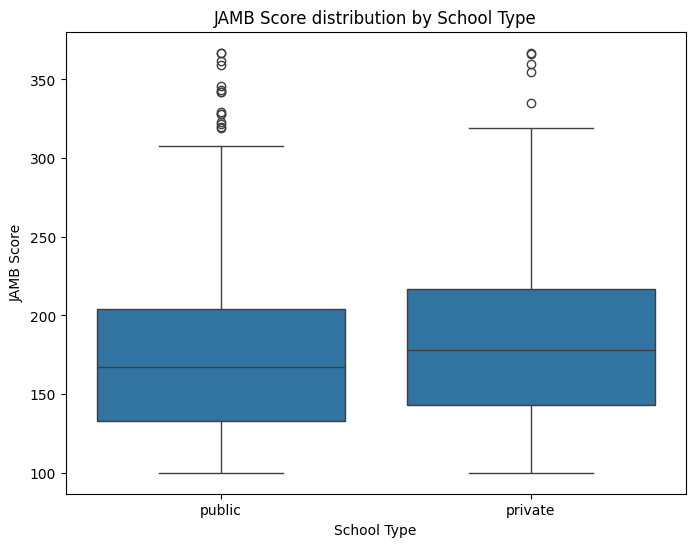

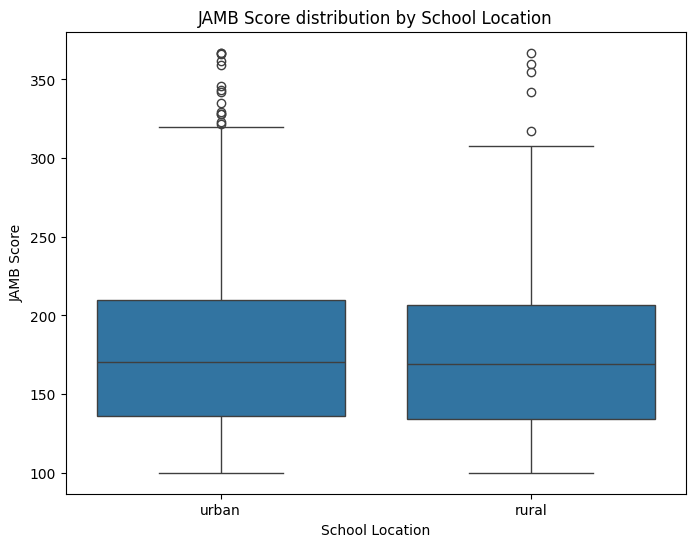

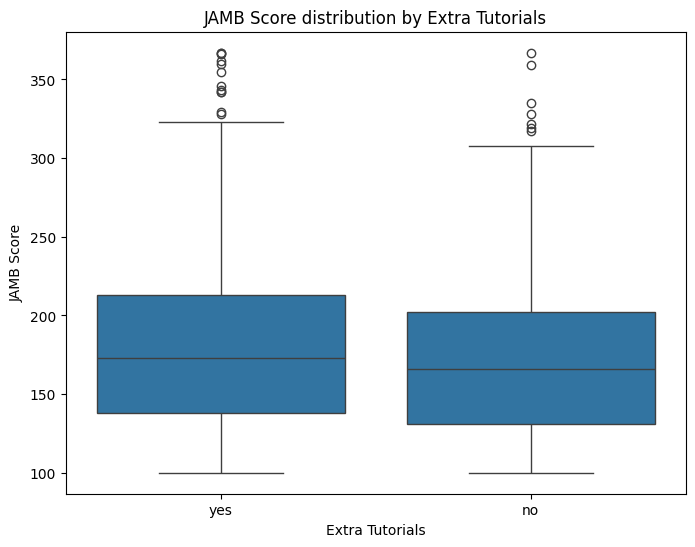

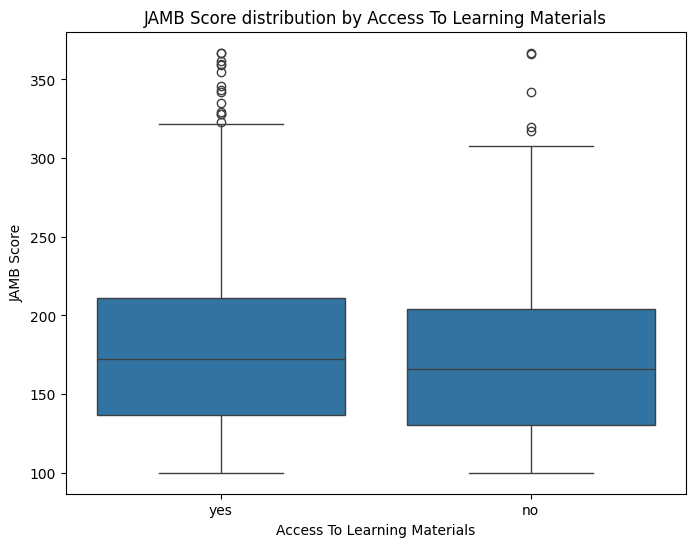

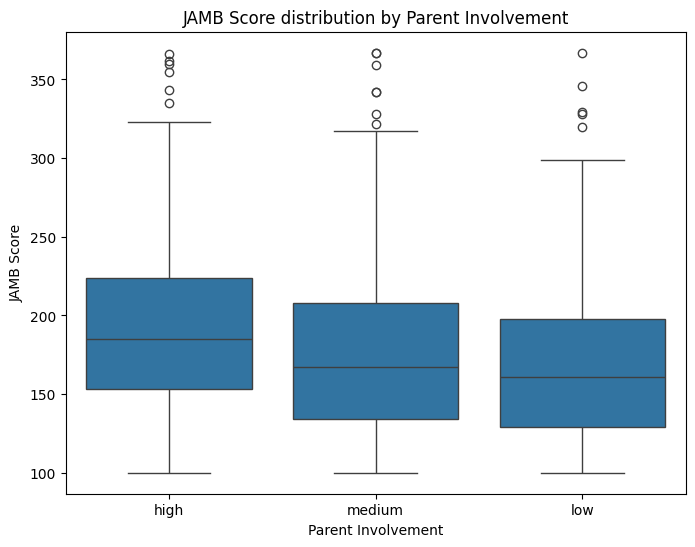

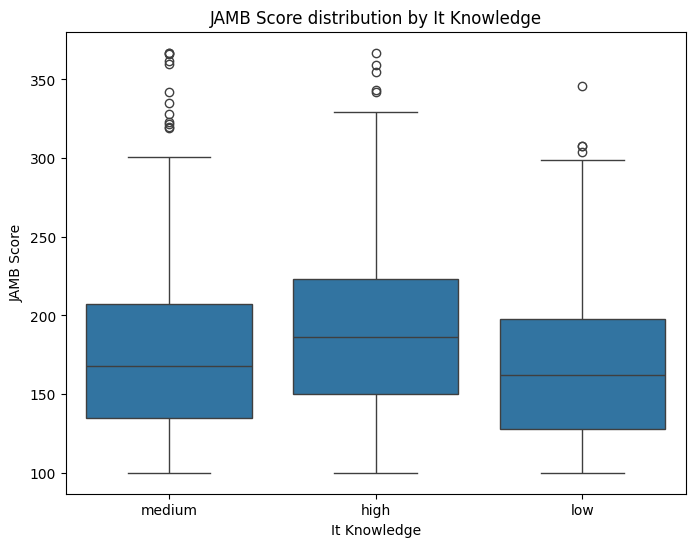

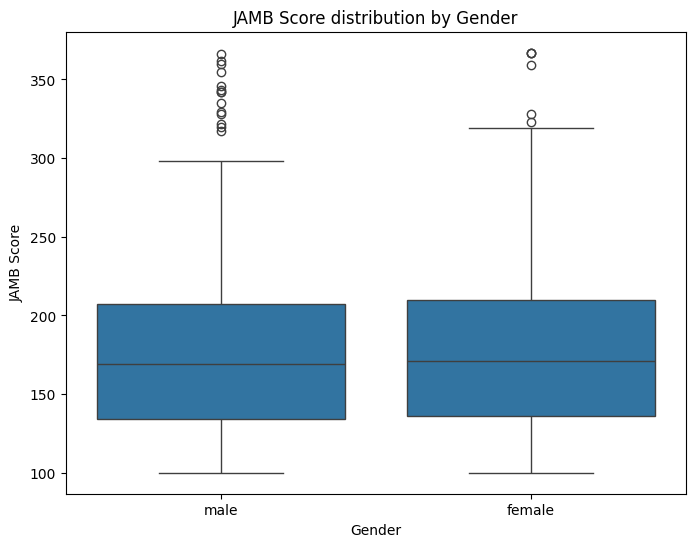

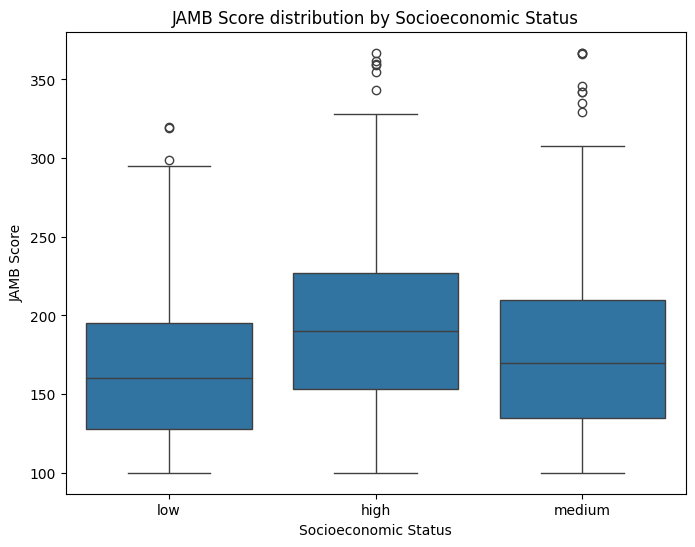

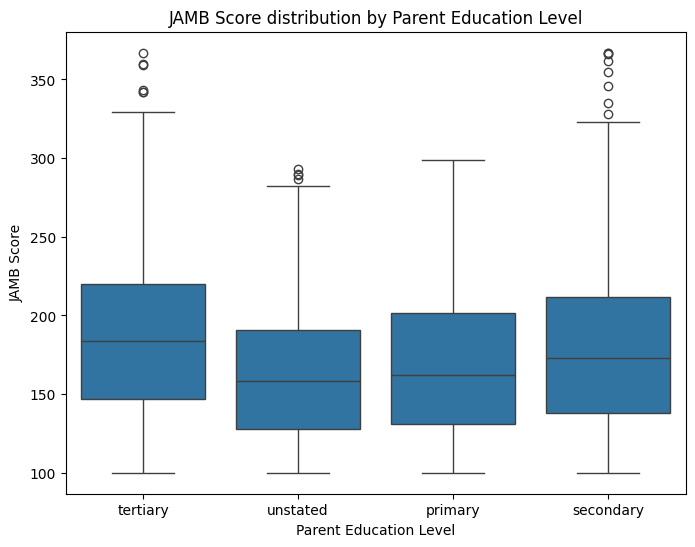

In [13]:
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, y='jamb_score', data=df)
    plt.title(f"JAMB Score distribution by {col.replace('_', ' ').title()}")
    plt.ylabel('JAMB Score')
    plt.xlabel(col.replace('_', ' ').title())
    plt.show()

The `teacher_quality` column, although encoded as numbers, is a categorical variable that assigns a rating to the student's tutor. It is an ordinal variable, meaning there is some meaning attached to the numbers. In this case, the category should be ordinally encoded in order to keep its meaning. We will plot a boxplot of the category to view the summary statistics and make possible inferences.

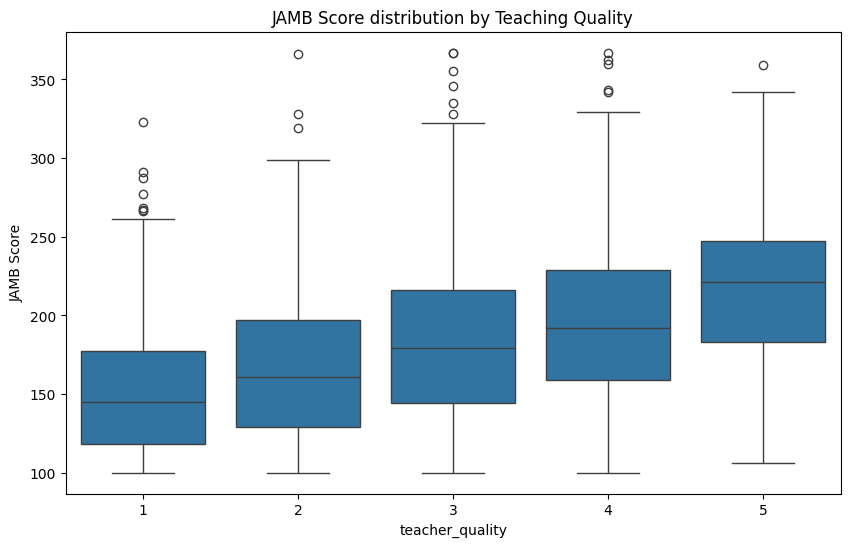

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='teacher_quality', y='jamb_score', data=df)
plt.title("JAMB Score distribution by Teaching Quality")
plt.ylabel("JAMB Score");

The boxplots above show disparities in median JAMB scores across categories for each feature, which can indicate potential influence on the target. Features such as `school_type`, `teacher_quality`, `parent_education_level`, `socioeconomic_status`, `IT_knowledge`, and `parent_involvement` show especially large median gaps. This is consistent with domain expectations: for example, a student with higher IT knowledge may perform better in a computer-based exam than an equally capable peer with minimal IT knowledge.

Outliers are present across all categories, indicating variability in performance regardless of a category’s typical advantage. For instance, in `teacher_quality`, students with the highest-rated teachers have only a single extreme score, whereas students with the lowest-rated teachers show several extreme scores.

While median differences highlight potentially important features, these patterns alone cannot establish causality. We will next calculate mutual information scores to quantify the strength of association between each feature and the target, providing a complementary measure of their relative predictive importance.

In [15]:
categorical_cols.append('teacher_quality')

In [16]:
def mutual_info_score_jamb(series):
    return mutual_info_score(series, df.jamb_score)

mutual_scores = df[categorical_cols].apply(mutual_info_score_jamb)

In [17]:
mutual_scores.sort_values(ascending=False)

teacher_quality                 0.135126
parent_education_level          0.078597
socioeconomic_status            0.065124
parent_involvement              0.059754
it_knowledge                    0.056660
school_type                     0.028125
extra_tutorials                 0.025080
school_location                 0.023480
access_to_learning_materials    0.022239
gender                          0.020896
dtype: float64

<Axes: >

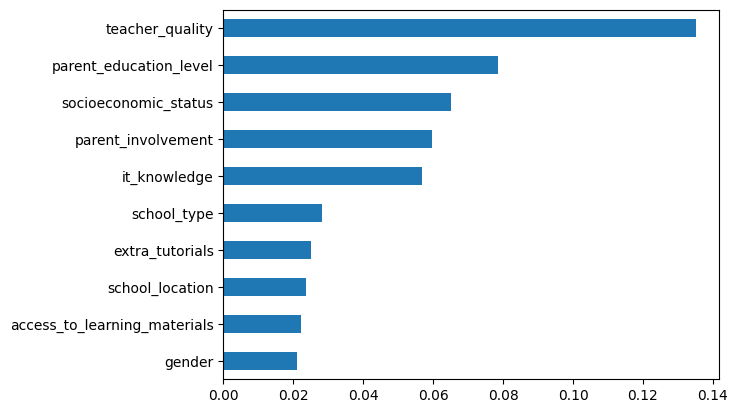

In [18]:
mutual_scores.sort_values(ascending=True).plot(kind='barh')

The bar chart of mutual information scores quantifies the strength of association between each categorical feature and the target. Features that exhibited large disparities in median scores across categories in the boxplots—such as teacher_quality, parent_education_level, and socioeconomic_status—also rank highest in mutual information, suggesting a consistent pattern between visual and statistical analyses.

While this alignment strengthens the case for their predictive importance, it does not imply causation. We will move on to the exploration of numerical features.

### Numerical features

In [19]:
numerical_cols = ['jamb_score', 'study_hours_per_week', 'attendance_rate', 'age', 'assignments_completed', 'distance_to_school']

First, we will take a look at the summary statistics for each numerical column.

In [20]:
df[numerical_cols].describe().round(3)

,jamb_score,study_hours_per_week,attendance_rate,age,assignments_completed,distance_to_school
count,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,174.075,19.521,84.235,18.446,1.805,10.005
std,47.616,9.635,9.486,2.302,0.992,4.820
min,100.000,0.000,50.000,15.000,1.000,0.000
25%,135.000,13.000,78.000,16.000,1.000,6.600
50%,170.000,19.000,84.000,18.000,1.000,10.000
75%,209.000,26.000,91.000,20.000,2.000,13.400
max,367.000,40.000,100.000,22.000,5.000,20.000


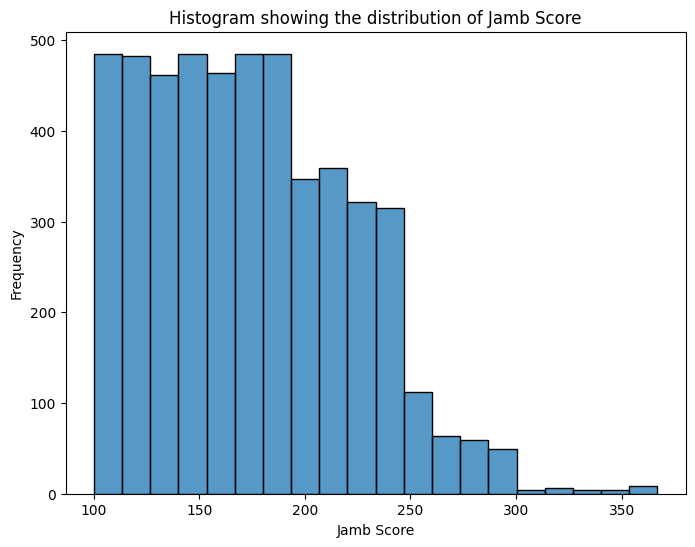

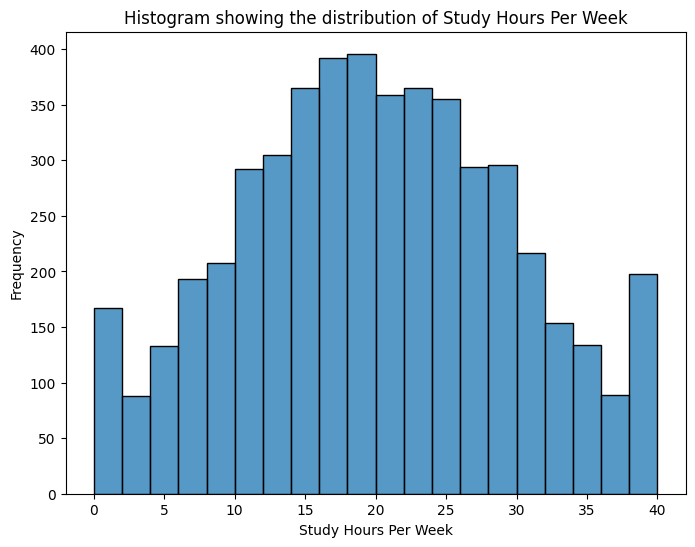

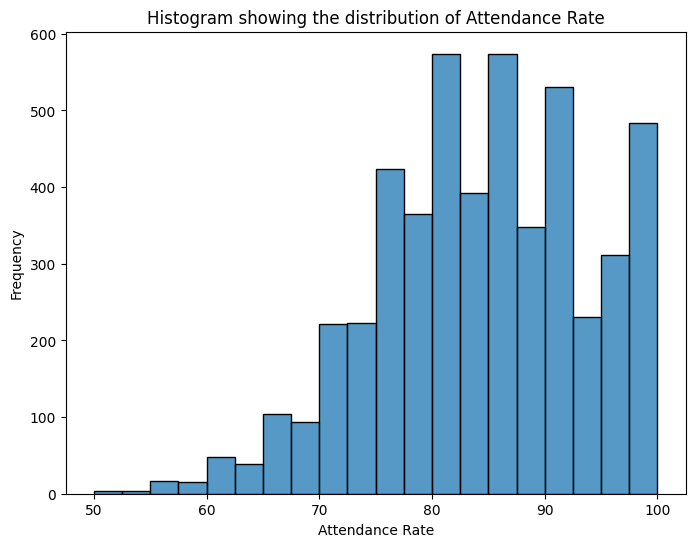

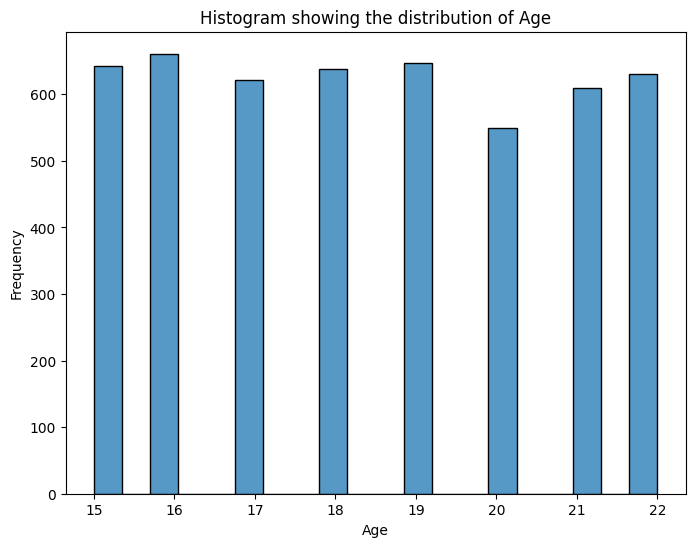

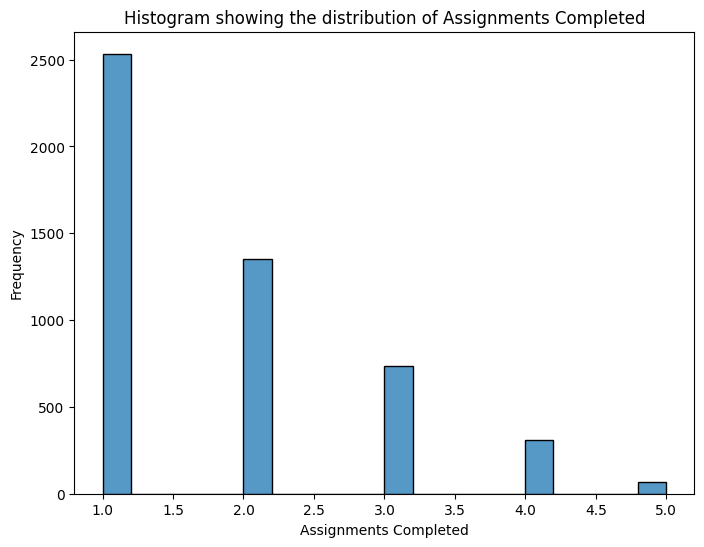

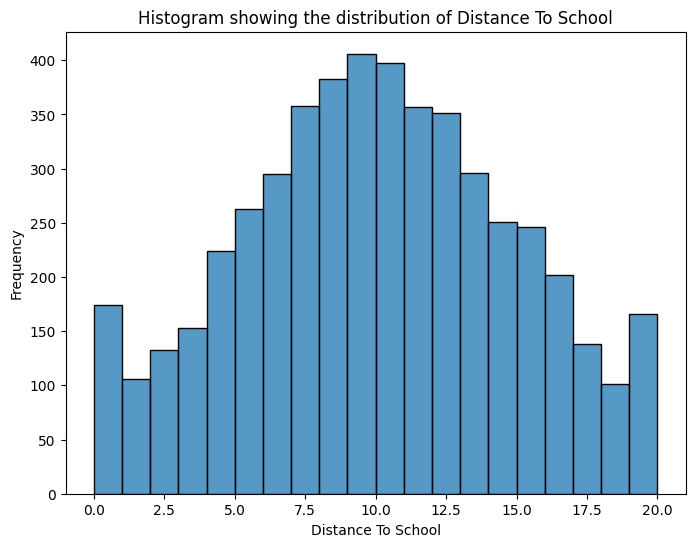

In [21]:

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], bins=20)
    plt.title(f"Histogram showing the distribution of {col.replace('_', ' ').title()}")
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel('Frequency')
    plt.show()

A summary of points to note from the histograms above:
- The target variable, test scores, are concentrated within the range of 100 to 250, and only a very little number of the population have scores above 300.
- The majority of students study for 10 to 30 hours every week. 
- Most of the students attended at least 70% of lectures.
- The ages are uniformly distributed.
- A large number of students completed only one assignment, there is a very steep decrease in the frequency of students as the number of completed assignments increase, with the number of students completing all 5 assignments being extremely low relative to the frequency of students that completed even 3 assignments.

Next, a heatmap of the correlations between these numerical columns will be plotted to test for multicollinearity. The `assignments_completed` column seems very interesting. A little more digging, and something might come to the light.

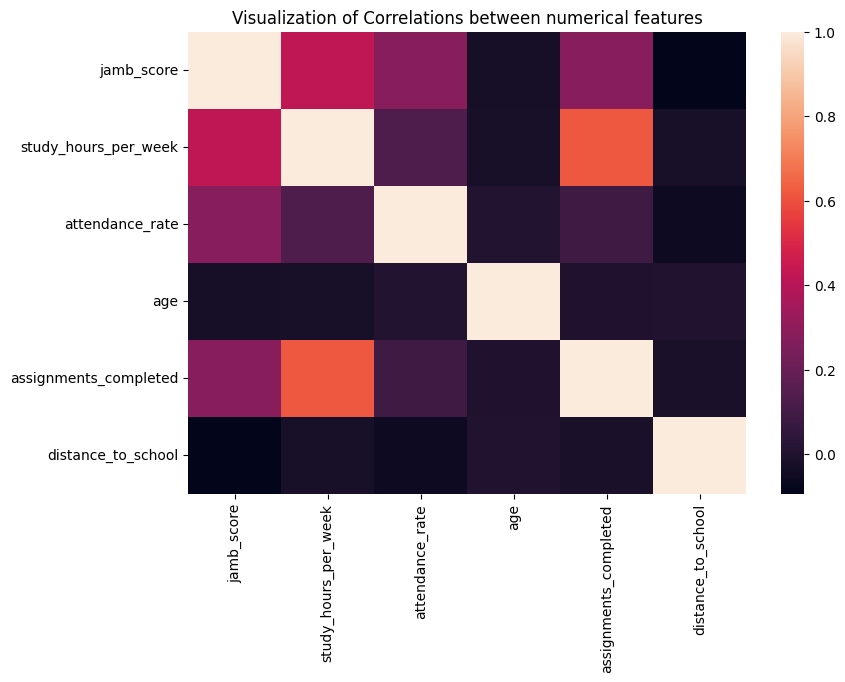

In [22]:
# heatmap of correlations
plt.figure(figsize=(9, 6))
sns.heatmap(df[numerical_cols].corr())
plt.title("Visualization of Correlations between numerical features");

Observations from the heatmap:
- Age and distance to school have incredibly low correlations with all of the other features.
- Most of the other columns have pretty moderate correlations with each other. 
- The one correlation that stands out here and is seemingly more than moderate is the correlation between `study_hours_per_week` and `assignments_completed`. We will look into that.

In [23]:
corr_val = df['study_hours_per_week'].corr(df['assignments_completed']).round(3)
print(
    f"The correlation between 'study_hours_per_week' and 'assignments_completed' is {corr_val}."
)

The correlation between 'study_hours_per_week' and 'assignments_completed' is 0.618.


There is a moderately high correlation between `study_hours_per_week` and `assignments_completed`, at a value `0.618`. This could be explained as demonstrated causation. It is totally plausible that the longer a student studies, the more they understand and are able to engage with the material, and the more enthusiastic they might be to take jabs at problems that could be solved using the tools the studied materials provide. This value, however, is not high enough to infer multicollinearity, so the two features will be utilized in training a predictive model.

Next, I would create a boxplot of the test scores for each category of the `assignments_completed` feature.

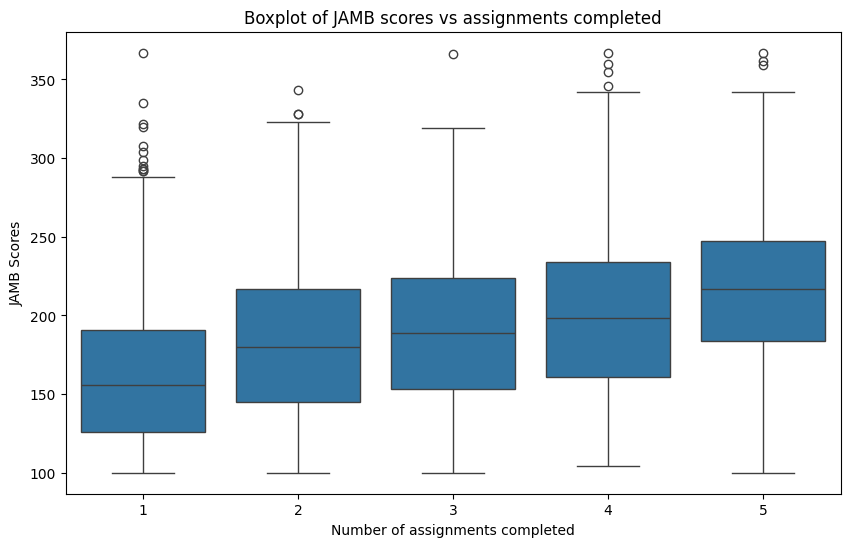

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='assignments_completed', y='jamb_score', data=df)
plt.title("Boxplot of JAMB scores vs assignments completed")
plt.ylabel("JAMB Scores")
plt.xlabel("Number of assignments completed");

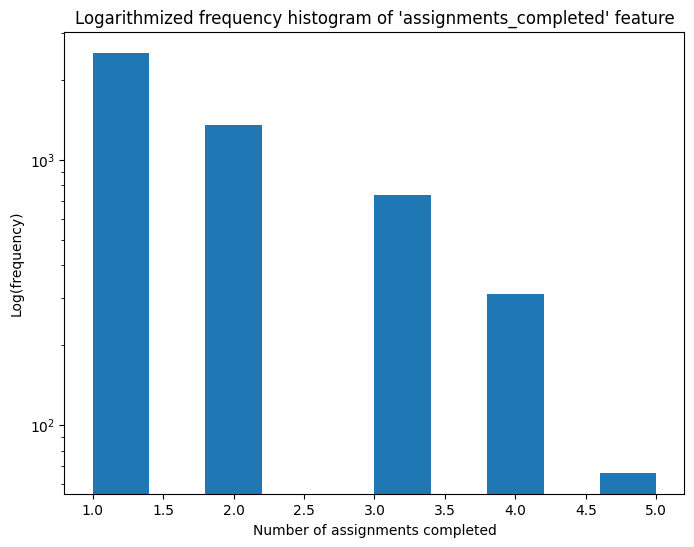

In [25]:
plt.figure(figsize=(8, 6))
df.assignments_completed.plot(kind='hist', logy=True)
plt.title("Logarithmized frequency histogram of 'assignments_completed' feature")
plt.xlabel("Number of assignments completed")
plt.ylabel("Log(frequency)");

The boxplot of each category of number of assignment completed shows that the median of test scores noticeably increases with an increase in the number of assignments completed. The histogram of the raw frequencies of the `assignments_completed` feature seemed to follow a power law distribution, and this hypothesis was explored by logarithmizing the frequency, and as can be seen above, the histogram seemed to be more linear now. It would be great to state here that the `assignments_completed` column is an ordinal categorical variable. Next, I would combine students with 4 and 5 completed assignments into one bin and then bin the study hours per week feature to dig deeper.

In [26]:
bins = [0, 1, 2, 3, 5]
labels = [1, 2, 3, 4]
df['assignments_completed_binned'] = pd.cut(df['assignments_completed'], bins=bins, labels=labels, include_lowest=True)

After this, I want to bin the `study_hours_per_week` feature to see whether there is a similar ordinality to this, though I guess there is. If there is, the two binned features will be combined in a feature cross.

In [27]:
df['study_hours_binned'] = pd.cut(df['study_hours_per_week'], bins=5, labels=[1, 2, 3, 4, 5])

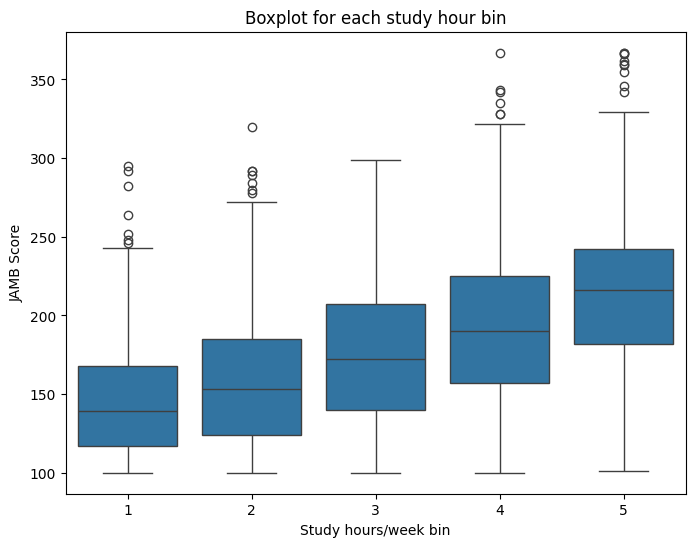

In [28]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='study_hours_binned', y='jamb_score', data=df)
plt.title('Boxplot for each study hour bin')
plt.xlabel('Study hours/week bin')
plt.ylabel('JAMB Score');

In [29]:
df['assignments_completed_binned'].corr(df['study_hours_binned'], method='spearman')

np.float64(0.6046453063350117)

The boxplot of each category of the binned study hours shows that the median of test scores noticeably increases with each bin, similar to the `assignments_completed` feature. I will combine these features using a feature cross.

In [30]:
df['study_assignments_cross'] = df['study_hours_binned'].astype(int) * 10 + df['assignments_completed_binned'].astype(int)

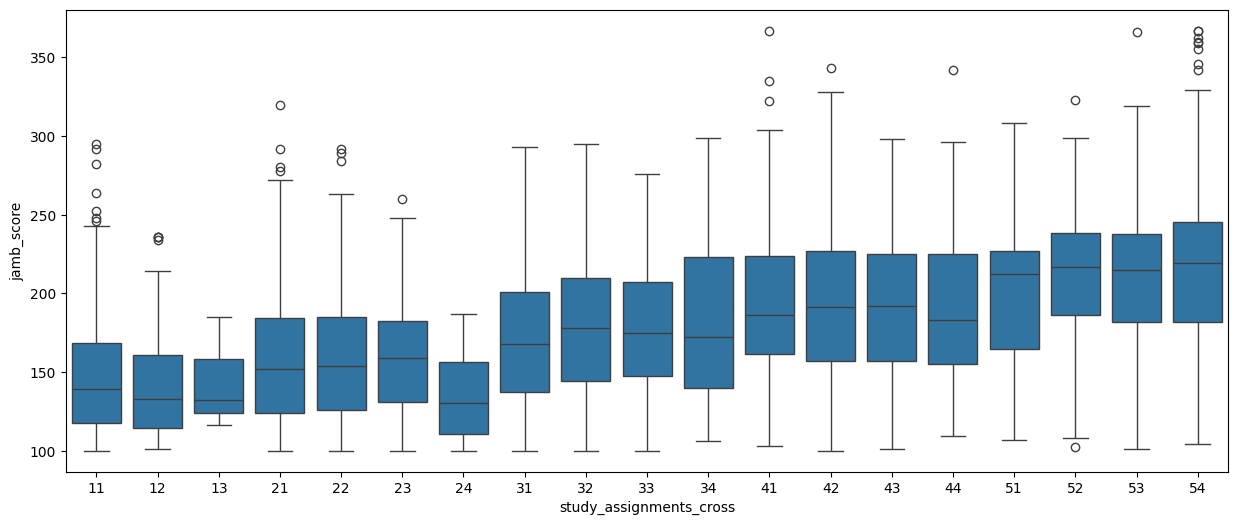

In [31]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='study_assignments_cross', y='jamb_score', data=df);

From this boxplot, it can be seen that there is a positive trend from left to right; higher cross-bin values generally lead to higher median JAMB scores. Some combinations seem to underperform relatively to the others e.g `24` representing students in the second bin of study hours that completed 4 assignments, but this is ultimately a good thing, as one could have just easily generalised. We will make use of this in the modeling stage. 

Next, I will look into attendance rate with respect to the target variable.

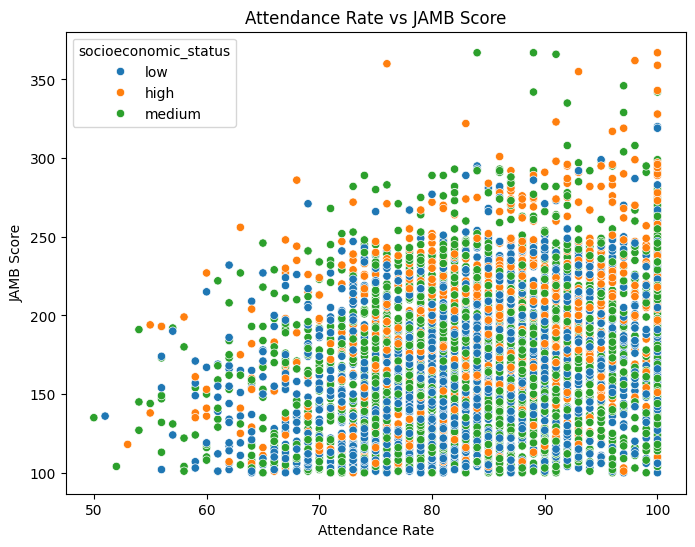

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='attendance_rate', y='jamb_score', hue='socioeconomic_status', data=df)
plt.title('Attendance Rate vs JAMB Score')
plt.xlabel('Attendance Rate')
plt.ylabel('JAMB Score');

Above is a scatter diagram examining attendance rate with the target variable, categorizing based on student socioeconomic status. The majority of students attended school at least 70 percent of the time. It has earlier on been established that students with scores above 300 are outliers. A (not so suprising) discovery here is that almost all of them come come from high or medium socioeconomic backgrounds. Next, I will compare school type and socioeconomic status in relation to the target variable.

In [33]:
interaction_stats = df.groupby(['school_type', 'socioeconomic_status'])['jamb_score'].mean().round(3).unstack()

print("Mean JAMB Scores by School Type and Socioeconomic Status:")
interaction_stats

Mean JAMB Scores by School Type and Socioeconomic Status:


socioeconomic_status,high,low,medium
school_type,,,
private,198.599,168.024,184.768
public,187.883,163.631,170.801


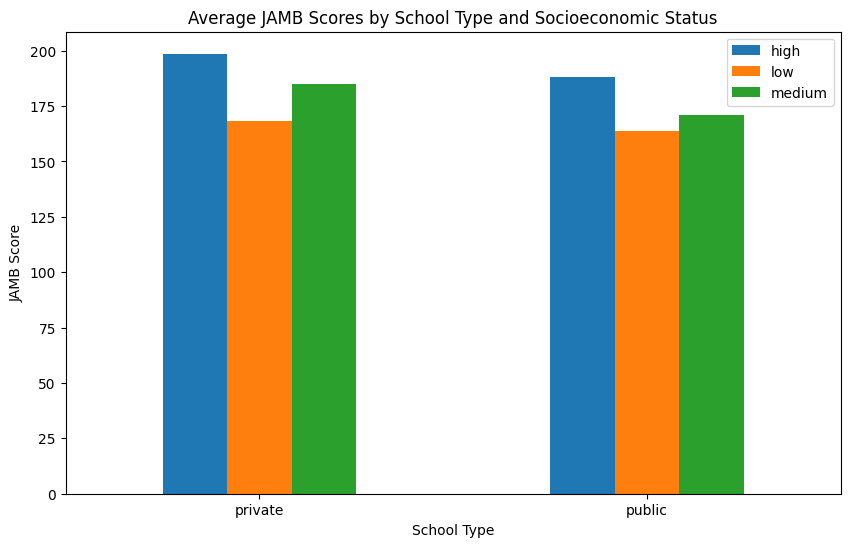

In [34]:
interaction_stats.plot(kind='bar', figsize=(10, 6))
plt.title("Average JAMB Scores by School Type and Socioeconomic Status")
plt.xlabel('School Type')
plt.xticks(rotation=0)
plt.ylabel('JAMB Score')
plt.legend(loc='upper right');

From the tables and plot, we can see the very clear distinction between average results based on school type, irrespective of socioeconomic status. On average, private school students perform better than students attending public schools. More especially so for students from middle class homes.

Lastly, we will examine the age column. It has been seen that the frequency of age is almost uniformly distributed. Also, we saw that there was very little correlation between age and all of the other numerical features, including the target variable. To dig further, I will bin the values of the feature to see if there is any hidden trend to be uncovered.

In [35]:
bins = [14, 17, 20, 23]
labels = ['15-17', '18-20', '21-22']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

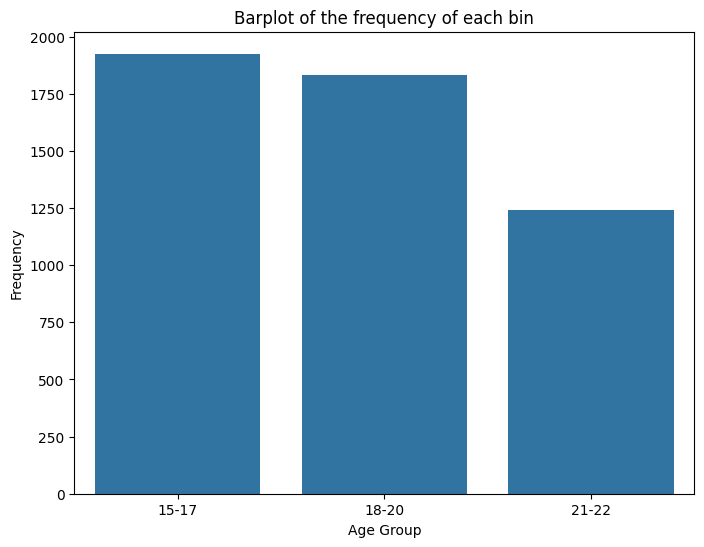

In [36]:
plt.figure(figsize=(8, 6))
sns.barplot(df.age_group.value_counts())
plt.title('Barplot of the frequency of each bin')
plt.ylabel('Frequency')
plt.xlabel('Age Group');

Age is literally uniformly distributed, and so, it makes sense that the `21-22` bin has a lesser count than the other two bins which contain 3 ages. It contains data for only two ages. Next, I will create a boxplot that compares the distribution of test scores for each age group.

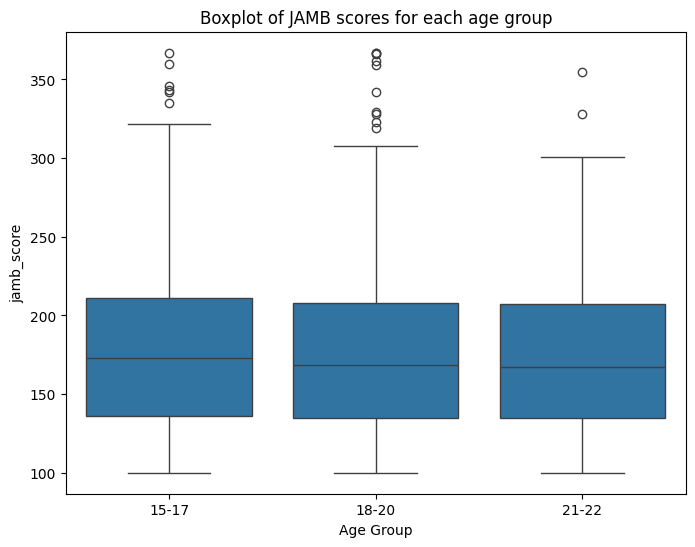

In [37]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='age_group', y='jamb_score', data=df)
plt.title('Boxplot of JAMB scores for each age group')
plt.xlabel('JAMB Score')
plt.xlabel('Age Group');

There is no major discrepancy or difference between results for each age group. The only noticeable observations are that there are more outlier results in the `18-20` age group, and the maximum scores differ a little but are all at least `300`. There is no major trend exposed by this new feature, but I will experiment with it in the model building phase.

### EDA Summary
- **Target Distribution:** JAMB scores are approximately normally distributed, with most students clustered around the mid-range, and fewer students at the extremes.  
- **Categorical Features:** Features such as gender, location, and teacher quality showed varying distributions but no severe imbalances that would hinder modeling.  
- **Numerical Features:** Variables like attendance rate and study hours displayed reasonable ranges, with some moderate skewness.  
- **Feature Engineering:**  
  - *Study Assignments* was grouped into bins (e.g., 4–5 completed assignments).  
  - A numeric cross-feature combining attendance rate and assignment completion was created and one-hot encoded.  
- **Correlations:** No single feature had a very strong linear relationship with the target, but moderate associations existed (e.g., between attendance, assignment completion, and JAMB score).  

**Interpretation:**  
The EDA revealed that while student behavior and background features show some relationship with JAMB scores, none appear dominant. This aligns with the modeling results where predictive power was limited.  


## Building the model

### Data Preprocessing

In [38]:
numerical_cols = ['study_hours_per_week', 'attendance_rate',
    'teacher_quality', 'student_id', 'age', 'assignments_completed', 'distance_to_school']

In [39]:
categorical_cols = list(df.dtypes[df.dtypes=='object'].index)

In [40]:
target = 'jamb_score'
y = df[target].values
X = df.drop(columns=[target])

In [41]:
# train/val/test split
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [42]:
def original_df(df):
    fresh_df = df[numerical_cols + categorical_cols]
    return fresh_df

def engineered_df(df, without_cross=True):
    if without_cross:
        engineered_df = df.drop(columns=['study_hours_per_week', 'age', 'assignments_completed', 'study_assignments_cross'])

    else:
        engineered_df = df.drop(columns=['study_hours_per_week', 'age', 'assignments_completed',
                                         'assignments_completed_binned', 'study_hours_binned'])

    return engineered_df

### Baseline Model
First, I will build baseline regression models using both raw features and engineered features. The evaluation metric that will be used is the `Root Mean Square Error (RMSE)`.

#### Raw features

In [43]:
def feature_transformer(cat_cols, num_cols, poly=False):
    if poly:
        column_transformer = ColumnTransformer(
            transformers = [
                ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
                ('poly', PolynomialFeatures(degree=2, include_bias=False), num_cols)
            ],
            remainder='passthrough'
        )

    else:
        column_transformer = ColumnTransformer(
            transformers = [
                ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
            ],
            remainder='passthrough'
        )

    return column_transformer

In [44]:
X_train_raw = original_df(X_train)
X_val_raw = original_df(X_val)

In [45]:
# for raw data
transformer = feature_transformer(categorical_cols, numerical_cols)

pipeline = Pipeline(
    [
        ('preprocessing', transformer),
        ('model', LinearRegression())
    ]
)

pipeline.fit(X_train_raw, y_train)

/home/samhulud/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type',
                                                   'school_location',
                                                   'extra_tutorials',
                                                   'access_to_learning_materials',
                                                   'parent_involvement',
                                                   'it_knowledge', 'gender',
                                                   'socioeconomic_status',
                                                   'parent_education_level'])])),
                ('model', LinearRegression())])

In [46]:
y_pred = pipeline.predict(X_val_raw)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'The RMSE of the baseline model using original features is {round(rmse, 3)}')

The RMSE of the baseline model using original features is 39.157


In [47]:
# after scaling numerical features
transformer = ColumnTransformer(
    transformers = [
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('scaler', MinMaxScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    [
        ('preprocessing', transformer),
        ('model', LinearRegression())
    ]
)

pipeline.fit(X_train_raw, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type',
                                                   'school_location',
                                                   'extra_tutorials',
                                                   'access_to_learning_materials',
                                                   'parent_involvement',
                                                   'it_knowledge', 'gender',
                                                   'socioeconomic_status',
                                                   'parent_education_level']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['study_hours_per_week',
                                                   'attendance_rate',
                                                   'teacher_quality',
                                                   'student_id', 'age',
                                                   'assignments_completed',
                                                   'distance_to_school'])])),
                ('model', LinearRegression())])

In [48]:
y_pred = pipeline.predict(X_val_raw)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'The RMSE of the baseline model using original features, with numerical features scaled, is {round(rmse, 3)}.')

The RMSE of the baseline model using original features, with numerical features scaled, is 39.157.


#### Engineered Features

In [49]:
X_train_eng = engineered_df(X_train, without_cross=True)
X_val_eng = engineered_df(X_val, without_cross=True)

In [50]:
engineered_cols_cat = ['age_group']
cat_col = categorical_cols + engineered_cols_cat

numerical_cols = ['attendance_rate', 'teacher_quality', 'distance_to_school', 'student_id']

In [51]:
# with engineered features excluding cross
transformer_eng = feature_transformer(cat_col, numerical_cols)

pipeline = Pipeline(
    [
        ('preprocessing', transformer_eng),
        ('model', LinearRegression())
    ]
)

pipeline.fit(X_train_eng, y_train)

/home/samhulud/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type',
                                                   'school_location',
                                                   'extra_tutorials',
                                                   'access_to_learning_materials',
                                                   'parent_involvement',
                                                   'it_knowledge', 'gender',
                                                   'socioeconomic_status',
                                                   'parent_education_level',
                                                   'age_group'])])),
                ('model', LinearRegression())])

In [52]:
y_pred = pipeline.predict(X_val_eng)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'The RMSE of the baseline model using engineered features excluding the feature cross is {round(rmse, 3)}.')

The RMSE of the baseline model using engineered features excluding the feature cross is 39.327.


In [53]:
X_train_eng_crossed = engineered_df(X_train, without_cross=False)
X_val_eng_crossed = engineered_df(X_val, without_cross=False)

In [54]:
engineered_cols_cat = ['age_group', 'study_assignments_cross']
cat_col = categorical_cols + engineered_cols_cat

numerical_cols = ['attendance_rate', 'teacher_quality', 'distance_to_school', 'student_id',
 'assignments_completed_binned', 'study_hours_binned']

In [55]:
# with engineered features including cross
transformer = feature_transformer(cat_col, numerical_cols)

pipeline = Pipeline(
    [
        ('preprocessing', transformer),
        ('model', LinearRegression())
    ]
)

pipeline.fit(X_train_eng_crossed, y_train)

/home/samhulud/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type',
                                                   'school_location',
                                                   'extra_tutorials',
                                                   'access_to_learning_materials',
                                                   'parent_involvement',
                                                   'it_knowledge', 'gender',
                                                   'socioeconomic_status',
                                                   'parent_education_level',
                                                   'age_group',
                                                   'study_assignments_cross'])])),
                ('model', LinearRegression())])

In [56]:
y_pred = pipeline.predict(X_val_eng_crossed)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'The RMSE of the baseline model using engineered features including the feature cross is {round(rmse, 3)}.')

The RMSE of the baseline model using engineered features including the feature cross is 39.459.


The baseline linear regression model performs pretty well, with a `RMSE` that is `22%` of the mean of the target variable. However, the engineered features do very little to make the model better. In fact, the model trained with engineered features has a negligibly worse performance than the model trained on original features. It is very negligible, but it is there. Also, while experimenting, I discovered that scaling the numerical features does not impact the model in any significant way.
Going forward, I will tune the model using the original features.

In [57]:
numerical_cols = ['study_hours_per_week', 'attendance_rate',
    'teacher_quality', 'student_id', 'age', 'assignments_completed', 'distance_to_school']

In [58]:
# after scaling numerical features
transformer = feature_transformer(categorical_cols, numerical_cols, poly=True)

pipeline = Pipeline(
    [
        ('preprocessing', transformer),
        ('model', LinearRegression())
    ]
)

pipeline.fit(X_train_raw, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type',
                                                   'school_location',
                                                   'extra_tutorials',
                                                   'access_to_learning_materials',
                                                   'parent_involvement',
                                                   'it_knowledge', 'gender',
                                                   'socioeconomic_status',
                                                   'parent_education_level']),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['study_hours_per_week',
                                                   'attendance_rate',
                                                   'teacher_quality',
                                                   'student_id', 'age',
                                                   'assignments_completed',
                                                   'distance_to_school'])])),
                ('model', LinearRegression())])

In [59]:
y_pred = pipeline.predict(X_val_raw)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f'The RMSE using polynomial features is: {round(rmse, 3)}.')

The RMSE using polynomial features is: 38.989.


In [60]:
engineered_cols_cat = ['age_group']
cat_col = categorical_cols + engineered_cols_cat

numerical_cols = ['attendance_rate', 'teacher_quality', 'distance_to_school', 'student_id']

In [61]:
# after scaling numerical features
transformer = feature_transformer(cat_col, numerical_cols, poly=True)

pipeline = Pipeline(
    [
        ('preprocessing', transformer),
        ('model', LinearRegression())
    ]
)

pipeline.fit(X_train_eng, y_train)

/home/samhulud/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type',
                                                   'school_location',
                                                   'extra_tutorials',
                                                   'access_to_learning_materials',
                                                   'parent_involvement',
                                                   'it_knowledge', 'gender',
                                                   'socioeconomic_status',
                                                   'parent_education_level',
                                                   'age_group']),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['attendance_rate',
                                                   'teacher_quality',
                                                   'distance_to_school',
                                                   'student_id'])])),
                ('model', LinearRegression())])

In [62]:
y_pred = pipeline.predict(X_val_eng)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE using engineered features, applying polynomial features to the numerical features: {round(rmse, 3)}.')

RMSE using engineered features, applying polynomial features to the numerical features: 39.272.


As is seen above, the model doesn't improve, even after the addition of a polynomial feature preprocessing step for numerical features to capture any non-linear trends that might be in the data. Next, I will tune a regularized linear regression model using the original features.

In [63]:
scores = []

for C in [0.001, 0.01, 0.1, 1, 2, 3, 5, 7, 10, 20, 50, 100]:
    # data preprocessing
    numerical_cols = ['study_hours_per_week', 'attendance_rate',
    'teacher_quality', 'student_id', 'age', 'assignments_completed', 'distance_to_school']
    
    X_train_raw = original_df(X_train)
    
    transformer = feature_transformer(categorical_cols, numerical_cols, poly=True)
    # model instance
    pipeline = Pipeline(
        [
            ('preprocessing', transformer),
            ('model', Ridge(alpha=C, random_state=1, max_iter=1000))
        ]
    )
    # training
    pipeline.fit(X_train_raw, y_train)
    # validation
    y_pred = pipeline.predict(X_val_raw)
    rmse = root_mean_squared_error(y_val, y_pred)
    # append to list 
    scores.append((C, rmse))

columns = ['alpha', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

/home/samhulud/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.79573e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/samhulud/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.7957e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/samhulud/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.79533e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/samhulud/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.79178e-18): result may not be accurate.
  return linalg.solve(A, X

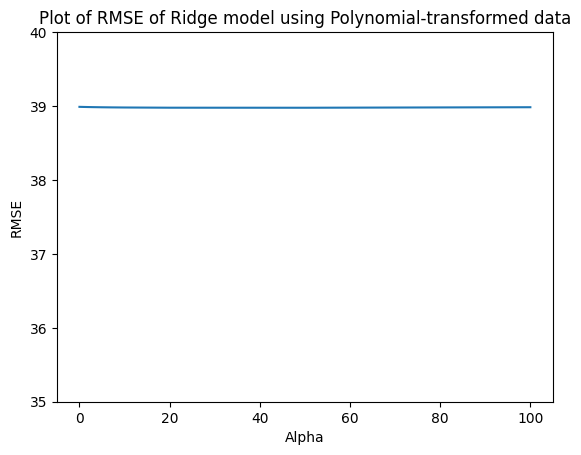

In [64]:
plt.plot(df_scores.alpha, df_scores.rmse)
plt.title('Plot of RMSE of Ridge model using Polynomial-transformed data')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.ylim([35, 40]);

In [65]:
scores = []

for C in [0.001, 0.01, 0.1, 1, 2, 3, 5, 7, 10, 20, 50, 100]:
    # data preprocessing
    numerical_cols = ['study_hours_per_week', 'attendance_rate',
    'teacher_quality', 'student_id', 'age', 'assignments_completed', 'distance_to_school']
    
    X_train_raw = original_df(X_train)
    
    transformer = feature_transformer(categorical_cols, numerical_cols, poly=False)
    # model instance
    pipeline = Pipeline(
        [
            ('preprocessing', transformer),
            ('model', Ridge(alpha=C, random_state=1, max_iter=1000))
        ]
    )
    # training
    pipeline.fit(X_train_raw, y_train)
    # validation
    y_pred = pipeline.predict(X_val_raw)
    rmse = root_mean_squared_error(y_val, y_pred)
    # append to list 
    scores.append((C, rmse))

columns = ['alpha', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

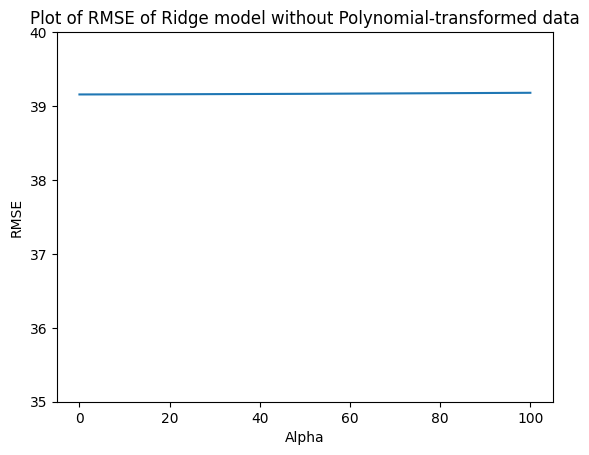

In [66]:
plt.plot(df_scores.alpha, df_scores.rmse)
plt.title('Plot of RMSE of Ridge model without Polynomial-transformed data')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.ylim([35, 40]);

As seen above, regularizing the linear regression does us little good, as the `RMSE` plot is basically a horizontal line that shows that changing the regularization factor does not improve the performance of the model. I will use the combination of the training and validation data to train the final model. The final model will use the original features, with the numerical features transformed with `PolynomialFeatures`.

### Final Model

In [67]:
numerical_cols = ['study_hours_per_week', 'attendance_rate',
    'teacher_quality', 'student_id', 'age', 'assignments_completed', 'distance_to_school']

In [68]:
X_full_train_raw = original_df(X_full_train)
X_test_raw = original_df(X_test)

In [69]:
# for raw data
transformer = feature_transformer(categorical_cols, numerical_cols, poly=True)

pipeline = Pipeline(
    [
        ('preprocessing', transformer),
        ('model', LinearRegression())
    ]
)

pipeline.fit(X_full_train_raw, y_full_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type',
                                                   'school_location',
                                                   'extra_tutorials',
                                                   'access_to_learning_materials',
                                                   'parent_involvement',
                                                   'it_knowledge', 'gender',
                                                   'socioeconomic_status',
                                                   'parent_education_level']),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['study_hours_per_week',
                                                   'attendance_rate',
                                                   'teacher_quality',
                                                   'student_id', 'age',
                                                   'assignments_completed',
                                                   'distance_to_school'])])),
                ('model', LinearRegression())])

In [70]:
y_pred = pipeline.predict(X_test_raw)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE of the final model: {round(rmse, 3)}')

RMSE of the final model: 38.687


In [85]:
cat_col = ['parent_education_level', 'socioeconomic_status', 'parent_involvement',
    'it_knowledge', 'school_type', 'extra_tutorials']
numerical_cols = ['study_hours_per_week', 'attendance_rate',
    'teacher_quality', 'assignments_completed', 'distance_to_school']

In [86]:
X_full_train_raw = X_full_train[cat_col + numerical_cols]
X_test_raw =X_test[cat_col + numerical_cols]

In [87]:
X_full_train_raw.dtypes

parent_education_level     object
socioeconomic_status       object
parent_involvement         object
it_knowledge               object
school_type                object
extra_tutorials            object
study_hours_per_week        int64
attendance_rate             int64
teacher_quality             int64
assignments_completed       int64
distance_to_school        float64
dtype: object

After training the final Ordinary Linear Regression model on the combined training and validation data, performance improved slightly.  
- **Previous RMSE:** 38.989  
- **Final RMSE (combined data):** 38.687  

While this performs better than the initial models, the improvement is merely marginal. 

## Conclusion and Results Communication  
The project set out to predict students’ JAMB scores using a mix of demographic, behavioral, and school-related features. Several modeling strategies were tested, including Ordinary Linear Regression, Ridge Regression with regularization tuning, and feature engineering approaches such as binning and polynomial features.  

Key findings:  
- Ordinary Linear Regression consistently performed as well as, or better than, more complex alternatives.  
- Polynomial feature expansion and Ridge regularization did not yield meaningful improvements.  
- The final model, trained on the combined training and validation sets, achieved an RMSE of **38.687**, only marginally better than earlier iterations.  

Overall, the results indicate that the predictive power of the available features is limited. While linear regression provides a baseline, significant performance gains would likely require richer or more relevant features, such as additional measures of study habits, socioeconomic background, or prior academic performance.  

Thus, the project demonstrates both the utility and the limits of regression models for predicting exam outcomes in this dataset

## Recommendations  
- **Data Enrichment:** The current feature set appears insufficient to capture the complexity of factors influencing JAMB performance. Collecting additional features such as prior test results, study habits, attendance records, and socioeconomic indicators may provide stronger predictive signals.  

- **Qualitative Insights:** Combining quantitative modeling with teacher feedback, survey data, or classroom performance could help uncover hidden drivers of student outcomes.  

- **Model Utility:** Given the current predictive limitations, the model should not be used for high-stakes decisions. Instead, it may serve as a baseline reference while further data is collected and explored.  

- **Future Work:** Explore longitudinal data (student performance over multiple terms) and more complex feature engineering approaches (e.g., interaction effects, time-based trends) before deploying predictive models in an educational setting.  